In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import json


import ritnet
from ritnet.dataset import IrisDataset, transform
from torch.utils.data import DataLoader 
from ritnet.opt import parse_args
from ritnet.models import model_dict
from ritnet.utils import get_predictions


In [8]:
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

if torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")

In [9]:
model = model_dict['densenet']
model  = model.to(device)
filename = '../../RITnet/best_model_previous.pkl'

In [10]:
if not os.path.exists(filename):
    print("model path not found !!!")
else:
    print('model load ok!')

model load ok!


In [11]:
model.load_state_dict(torch.load(filename))
model = model.to(device)
model.eval()

DenseNet2D(
  (down_block1): DenseNet2D_down_block(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv21): Conv2d(33, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv31): Conv2d(65, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv32): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool): AvgPool2d(kernel_size=None, stride=None, padding=0)
    (relu): LeakyReLU(negative_slope=0.01)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
    (dropout3): Dropout(p=0.2, inplace=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down_block2): DenseNet2D_down_block(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv21): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (conv22): Conv2d(32, 32, kernel_size=(3, 3), stride=

In [12]:
test_set = IrisDataset(filepath = 'Semantic_Segmentation_Dataset/',\
                                 split = 'test',transform = transform)
    
testloader = DataLoader(test_set, batch_size = 4,
                             shuffle=False, num_workers=2)

FileNotFoundError: [Errno 2] No such file or directory: 'Semantic_Segmentation_Dataset/test/images'

In [51]:
test_set.

In [9]:
counter=0
    
os.makedirs('test/labels/',exist_ok=True)
os.makedirs('test/output/',exist_ok=True)
os.makedirs('test/mask/',exist_ok=True)

In [32]:
import nia22
import cv2

In [33]:
ddir = "./SampleData/"

fn_json = ddir + "json/mobile_C_A_H1_02.json"
fn_jpg  = fn_json.replace("json", "jpg")

img = cv2.cvtColor(cv2.imread(fn_jpg), cv2.COLOR_BGR2RGB)

In [35]:
anno = json.load(open("./SampleData/json/mobile_C_A_H1_02.json"))

eye = nia22.eyes.Eye(anno["Annotations"]["image"]["annotations"])

In [38]:
area, cropped = nia22.eyes.crop_eye(img, np.array(eye.l_eyelid['points']))

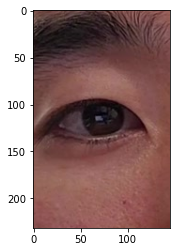

In [39]:
plt.imshow(cropped)

In [40]:
from ritnet.dataset import MaskToTensor

In [41]:
img_tensor = MaskToTensor()(cropped)

In [42]:
model(img_tensor)

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[1, 232, 146, 3] to have 1 channels, but got 232 channels instead

In [50]:
cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB).shape

(232, 146, 3)

In [46]:
data.shape

torch.Size([3, 1, 640, 400])

In [55]:
import os.path as osp
from torch.utils.data import Dataset 

class IrisDataset(Dataset):
    def __init__(self, filepath, split='test',transform=None,**args):
        self.transform = transform
        self.filepath= osp.join(filepath,split)
        self.split = split
        listall = []
        
        for file in os.listdir(osp.join(self.filepath,'images')):   
            if file.endswith(".png"):
                listall.append(file.strip(".png"))
        self.list_files=listall

        self.testrun = args.get('testrun')
        
        #PREPROCESSING STEP FOR ALL TRAIN, VALIDATION AND TEST INPUTS 
        #local Contrast limited adaptive histogram equalization algorithm
        self.clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))

    def __len__(self):
        if self.testrun:
            return 10
        return len(self.list_files)

    def __getitem__(self, idx):
        imagepath = osp.join(self.filepath,'images',self.list_files[idx]+'.png')
        pilimg = Image.open(imagepath).convert("L")
        H, W = pilimg.width , pilimg.height
       
        #PREPROCESSING STEP FOR ALL TRAIN, VALIDATION AND TEST INPUTS 
        #Fixed gamma value for      
        table = 255.0*(np.linspace(0, 1, 256)**0.8)
        pilimg = cv2.LUT(np.array(pilimg), table)
        

        if self.split != 'test':
            labelpath = osp.join(self.filepath,'labels',self.list_files[idx]+'.npy')
            label = np.load(labelpath)    
            label = np.resize(label,(W,H))
            label = Image.fromarray(label)     
               
        if self.transform is not None:
            if self.split == 'train':
                if random.random() < 0.2: 
                    pilimg = Starburst_augment()(np.array(pilimg))  
                if random.random() < 0.2:
                    pilimg = Gaussian_blur()(np.array(pilimg))   
                if random.random() < 0.4:
                    pilimg, label = Translation()(np.array(pilimg),np.array(label))
                
        img = self.clahe.apply(np.array(np.uint8(pilimg)))    
        img = Image.fromarray(img)      
            
        if self.transform is not None:
            if self.split == 'train':
                img, label = RandomHorizontalFlip()(img,label)
            img = self.transform(img)    


        if self.split != 'test':
            ## This is for boundary aware cross entropy calculation
            spatialWeights = cv2.Canny(np.array(label),0,3)/255
            spatialWeights=cv2.dilate(spatialWeights,(3,3),iterations = 1)*20
            
            ##This is the implementation for the surface loss
            # Distance map for each class
            distMap = []
            for i in range(0, 4):
                distMap.append(one_hot2dist(np.array(label)==i))
            distMap = np.stack(distMap, 0)           
#            spatialWeights=np.float32(distMap) 
            
            
        if self.split == 'test':
            ##since label, spatialWeights and distMap is not needed for test images
            return img,0,self.list_files[idx],0,0
            
        label = MaskToTensor()(label)
        return img, label, self.list_files[idx],spatialWeights,np.float32(distMap) 

In [56]:
dset = IrisDataset("./SampleData/png/")

FileNotFoundError: [Errno 2] No such file or directory: './SampleData/png/train/images'

100%|████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.35it/s]


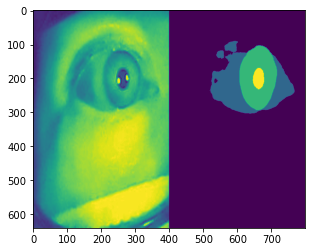

In [44]:
with torch.no_grad():
    for i, batchdata in tqdm(enumerate(testloader),total=len(testloader)):
        img,labels,index,x,y= batchdata
        data = img.to(device)       
        output = model(data)            
        predict = get_predictions(output)
        for j in range (len(index)):       
            np.save('test/labels/{}.npy'.format(index[j]),predict[j].cpu().numpy())
            try:
                plt.imsave('test/output/{}.jpg'.format(index[j]),255*labels[j].cpu().numpy())
            except:
                pass
                
            pred_img = predict[j].cpu().numpy()/3.0
            inp = img[j].squeeze() * 0.5 + 0.5
            img_orig = np.clip(inp,0,1)
            img_orig = np.array(img_orig)
            combine = np.hstack([img_orig,pred_img])
            plt.imsave('test/mask/{}.jpg'.format(index[j]),combine)
            plt.imshow(combine)

In [20]:
# single image test

In [80]:
from PIL import Image
import cv2
import numpy as np
from torchvision import transforms

In [141]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

In [142]:
img = Image.open('Semantic_Segmentation_Dataset/test/images/NIA_EYE_U1_053_VR_IR_F_REYE_0901.png').convert("L")
H, W = img.width , img.height

table = 255.0*(np.linspace(0, 1, 256)**0.8)
img = cv2.LUT(np.array(img), table)
clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
img = clahe.apply(np.array(np.uint8(img)))    
img = Image.fromarray(img)
img = np.array(img)
img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=0)
#img = transform(img)
# img = np.array(img)
# img = np.expand_dims(img, axis=0)
img = torch.from_numpy(img).type(torch.FloatTensor)

In [143]:
data = img.to(device)
output = model(data)

In [150]:
predict = get_predictions(output)
pred_img = predict.cpu().numpy()/3.0

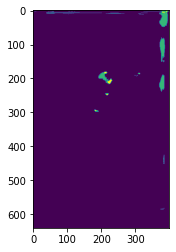

In [152]:
plt.imshow(pred_img[0])